In [1]:
import numpy as np
import torch
from torchvision import transforms
import cv2
import matplotlib
import matplotlib.pyplot as plt
from XAI import IntegratedGradients, attribution_mask_processing, GradCAM, FeatureMaps
from models import VGGFace, NCNN
from torchvision import models
import torch.nn as nn


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from math import ceil

def plot_image_grid(images, masks, alphas=None, grid_size=None, figsize=(10, 10), img_size=224):
    """
    Plots images with their corresponding masks in a grid.

    Parameters:
        images (list): List of PIL images.
        masks (list): List of masks (NumPy arrays) corresponding to each image.
        grid_size (tuple, optional): (rows, cols) for the grid. If None, it auto-calculates a square layout.
        figsize (tuple, optional): Figure size for the plot.
    """
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])
    num_images = len(images)
    
    # Determine grid size automatically if not provided
    if grid_size is None:
        cols = ceil(np.sqrt(num_images))
        rows = ceil(num_images / cols)
    else:
        rows, cols = grid_size

    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = np.array(axes).reshape(-1)  # Flatten in case of inconsistent shapes
    
    for i, ax in enumerate(axes):
        if i < num_images:
            img_resized = images[i].resize((img_size, img_size))
            mask_resized = masks[i]
            alphas_resized = alphas[i] if alphas is not None else None

            ax.imshow(img_resized)
            if alphas is not None:
                ax.imshow(mask_resized, alpha=alphas_resized, cmap=cmap)
            else:
                ax.imshow(mask_resized, alpha=0.5, cmap=cmap)  # Overlay mask with transparency
            ax.axis("off")
        else:
            ax.axis("off")  # Hide empty subplots
    
    plt.tight_layout()
    plt.show()


### Load model

In [ ]:
model = NCNN()
#model.load_state_dict(torch.load('experiments\\20250310_2005_NCNN\\Model\\best_model.pt', map_location=torch.device('cpu'))) 
model.load_state_dict(torch.load('experiments\\20250310_1955_NCNN\\Model\\best_model.pt', map_location=torch.device('cpu'))) #pretreinado
model.eval()

### Define image pre-processing

More information about models pre-processing can be found in ``dataloaders``.

In [ ]:
# Define the required transformations for the VGGNB
img_size = 224
transform = transforms.Compose([     
            transforms.ToTensor(),
            transforms.Resize((img_size,img_size)),
            transforms.Normalize(
                mean=[0.36703529, 0.41083294, 0.50661294], std=[1, 1, 1])
        ])

In [ ]:
img_size = 120
transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.52026823, 0.40445255, 0.34655508],
                                std=[0.28127891, 0.24436931, 0.23583611])
                
        ])

In [ ]:
img_size = 120
transform = transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
        ])

### Load the image

In [ ]:
import os
from PIL import Image

images = []
path_img = f'Datasets\\Folds\\0\\Test'

for img in os.listdir(path_img):
    if ".jpg" in img:
        image = Image.open(os.path.join(path_img,img)).convert("RGB")
        image = image.resize((img_size,img_size))
        images.append(image)



In [ ]:
transformed_images = torch.stack([transform(image) for image in images])


## TeST FEATURE MAPS

In [ ]:
test = FeatureMaps(model, model.VGGFace.features.conv5_3, 'cuda')

In [ ]:
mask_test = torch.tensor(test.get_featuremaps(transformed_images))

In [ ]:
mask_test.unsqueeze(0).shape

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def pca(feats, dim=3, fit_pca=None):
    B, C, H, W = feats.shape
    x = feats.permute(1, 0, 2, 3).reshape(C, B * H * W).permute(1, 0).detach().cpu().numpy()
    if fit_pca is None:
        fit_pca = PCA(n_components=dim).fit(x)
    x_red = torch.from_numpy(fit_pca.transform(x))
    x_red -= x_red.min(dim=0, keepdim=True).values
    x_red /= x_red.max(dim=0, keepdim=True).values
    return x_red.reshape(B, H, W, dim).permute(0, 3, 1, 2).to(feats.device), fit_pca

In [ ]:
dim = 3

In [ ]:
pca_test, fit_pca = pca(mask_test, dim=dim)

In [ ]:
pca_test.shape

In [ ]:
i = 0

new_pca = np.array(pca_test[i].permute(1,2,0).detach().cpu())
mask_testt = cv2.resize(new_pca,(224,224))

plt.figure(figsize=(15,5))
plt.subplot(1,4,1)
plt.imshow(images_RGB[i])
plt.imshow(mask_testt, alpha=0.8)
plt.axis('off')

plt.subplot(1,4,2)
plt.imshow(mask_testt[:,:,0], alpha=0.8)
plt.axis('off')

plt.subplot(1,4,3)
plt.imshow(mask_testt[:,:,1], alpha=0.8)
plt.axis('off')

plt.subplot(1,4,4)
plt.imshow(mask_testt[:,:,2], alpha=0.8)
plt.axis('off')

In [ ]:
mask_testt.max()

In [ ]:

torch.cuda.empty_cache()

### Create IG and GC object

Instatiate the Integrated Gradients and GradCam, for the GradCAM we are going to use the ``conv5_3`` layer as target.

In [ ]:
ig = IntegratedGradients(model, device='cuda')
gradcam = GradCAM(model, model.conv_4, device='cuda')

In [ ]:
transformed_images.shape

Generates attribution masks based on provide image and target class.

In [ ]:
# Generate the attribution mask
mask_ig = ig.attribution_mask(transformed_images)
mask_gc = gradcam.attribution_mask(transformed_images)

In [ ]:
i = 0

In [ ]:
plt.subplot(1,2,1)
plt.imshow(mask_ig[i])
plt.axis('off')
plt.title('Attribution Mask IG')

plt.subplot(1,2,2)
plt.imshow(mask_gc[i])
plt.axis('off')
plt.title('Attribution Mask GC')

This is a very poor visualization of the attribution mask. But using the below method we can enhance the visualisation and provide visual understanding of the model's predictions.

### Attribution mask post-processing

Attribution mask post-processing aims to remove redundant information from the original attribution masks, making visualisation and comparisson easier.

There are several parameters that can be tweaked in order to achieve better visualisations on ``attribution_mask_post_processing``.

In [ ]:
result_cam = []
alpha_channel_cam = []

for mask in mask_gc:
    gc_post, gc_alpha = attribution_mask_processing(mask)
    result_cam.append(gc_post)
    alpha_channel_cam.append(gc_alpha)

result_ig = []
alpha_channel_ig = []

for mask in mask_ig:
    ig_post, ig_alpha = attribution_mask_processing(mask)
    result_ig.append(ig_post)
    alpha_channel_ig.append(ig_alpha)

### Final visualization

In [ ]:
# Define the plot colors
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green","yellow","red"])

# Plot                                                    
plt.subplot(2,2,1)
plt.title('IG')
plt.imshow(mask_ig[i])
plt.imshow(images[i], alpha=0.5)
plt.axis('off')

plt.subplot(2,2,2)
plt.title('IG with Post-Processing')
plt.imshow(images[i])
plt.imshow(result_ig[i], cmap=cmap, alpha=alpha_channel_ig[i])
plt.axis('off')

plt.subplot(2,2,3)
plt.title('GC')
plt.imshow(mask_gc[i])
plt.imshow(images[i], alpha=0.5)
plt.axis('off')

plt.subplot(2,2,4)
plt.title('GC with Post-Processing')
plt.imshow(images[i])
plt.imshow(result_cam[i], cmap=cmap, alpha=alpha_channel_cam[i])
plt.axis('off')

plt.show()

In [ ]:
predictions = model.predict(transformed_images.to('cuda'))

In [ ]:
predictions[i]

In [ ]:
plot_image_grid(images, result_cam, alpha_channel_cam, figsize=(15, 15), img_size=img_size)

In [3]:
import torch.nn as nn
import os
from PIL import Image
import torch
from torchvision import models, transforms
from XAI import IntegratedGradients, attribution_mask_processing, GradCAM, FeatureMaps
import matplotlib.pyplot as plt
from models import *

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model = iresnet50()
checkpoint = torch.load('D:\\Doutorado\\Cassia Test\\R50\\backbone (1).pth', map_location=device, weights_only=False)
model.load_state_dict(checkpoint)

In [6]:
model = VGG16ArcFace()

checkpoint = torch.load('D:\\Doutorado\\Cassia Test\\ms1mv3_arcface_VGG16\\model.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [5]:
model = PainClassifier()

#checkpoint = torch.load('D:\\Doutorado\\Cassia Test\\ms1mv3_arcface_VGG16BN\\ms1mv3_arcface_VGG16\\model.pt', map_location=device, weights_only=False)
#model.load_state_dict(checkpoint)


In [5]:
model = VGGFace()
model.VGGFace.classifier = nn.Sequential(
    nn.Linear(25088, 1))

checkpoint = torch.load('D:\\Doutorado\Mestrado\\experiments\\VGGFACE_FINETUNE_LAST_CONV\\20250525_1540_VGGFace\\Model\\best_model.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint)


<All keys matched successfully>

In [ ]:
model = NCNN()
model.classifier = nn.Sequential(nn.Linear(1600,512, bias=False),
                                 nn.BatchNorm1d(512))

checkpoint = torch.load('D:\\Doutorado\\Cassia Test\\ms1mv3_arcface_NCNN\\model.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint)


In [6]:

img_size = 224
val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225]),
    ])

In [7]:

img_size = 224
val_transforms = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])

In [8]:
model = model.to(device)
model.eval()

VGG16ArcFace(
  (vgg): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16

In [9]:
import os

images = []
path_img = f'Datasets\\Folds\\0\\Test'
#path_img = 'D:\\Doutorado\\Cassia Test\\CassiaWebFace\\val\\000030'

for img in os.listdir(path_img):
    if ".jpg" in img:
        image = Image.open(os.path.join(path_img,img)).convert("RGB")
        images.append(image)

transformed_images = torch.stack([val_transforms(image) for image in images])

In [10]:
transformed_images[0]

tensor([[[ 0.1922,  0.2157,  0.0431,  ...,  0.2627,  0.2549,  0.2471],
         [ 0.1922,  0.2235,  0.0667,  ...,  0.2784,  0.2706,  0.2627],
         [ 0.0510,  0.2000,  0.1059,  ...,  0.2863,  0.2784,  0.2627],
         ...,
         [ 0.3412,  0.3725,  0.4275,  ...,  0.3255,  0.2706,  0.2235],
         [ 0.3412,  0.3961,  0.4510,  ...,  0.3255,  0.2784,  0.2157],
         [ 0.3333,  0.3725,  0.4196,  ...,  0.3176,  0.2627,  0.2078]],

        [[ 0.0510,  0.0745, -0.0980,  ...,  0.2078,  0.2157,  0.2157],
         [ 0.0510,  0.0745, -0.1137,  ...,  0.2235,  0.2314,  0.2314],
         [-0.0824,  0.0275, -0.1137,  ...,  0.2314,  0.2392,  0.2314],
         ...,
         [ 0.0667,  0.0667,  0.0510,  ...,  0.2392,  0.1608,  0.1137],
         [ 0.1765,  0.2235,  0.2471,  ...,  0.2471,  0.1843,  0.1216],
         [ 0.2314,  0.2863,  0.3255,  ...,  0.2471,  0.1922,  0.1373]],

        [[ 0.0196,  0.0353, -0.1529,  ...,  0.1451,  0.1529,  0.1373],
         [ 0.0196,  0.0353, -0.1529,  ...,  0

In [11]:
transformed_images.shape

torch.Size([109, 3, 224, 224])

In [12]:
images[0].size

(512, 512)

In [ ]:
#NCNN
gradcam = GradCAM(model, model.merge_branch[0], reshape_transform_ViT=False, device=device)
mask_gc = gradcam.attribution_mask(transformed_images)

In [12]:
#VGG
gradcam = GradCAM(model, model.VGGFace.features.conv5_3, reshape_transform_ViT=False, device=device)
mask_gc = gradcam.attribution_mask(transformed_images)

In [13]:
#PainClassifier
gradcam = GradCAM(model, model.vgg.features[28], reshape_transform_ViT=False, device=device)
mask_gc = gradcam.attribution_mask(transformed_images)

In [ ]:
#R50
gradcam = GradCAM(model, model.layer4[2].conv2, reshape_transform_ViT=False, device=device)
mask_gc = gradcam.attribution_mask(transformed_images)

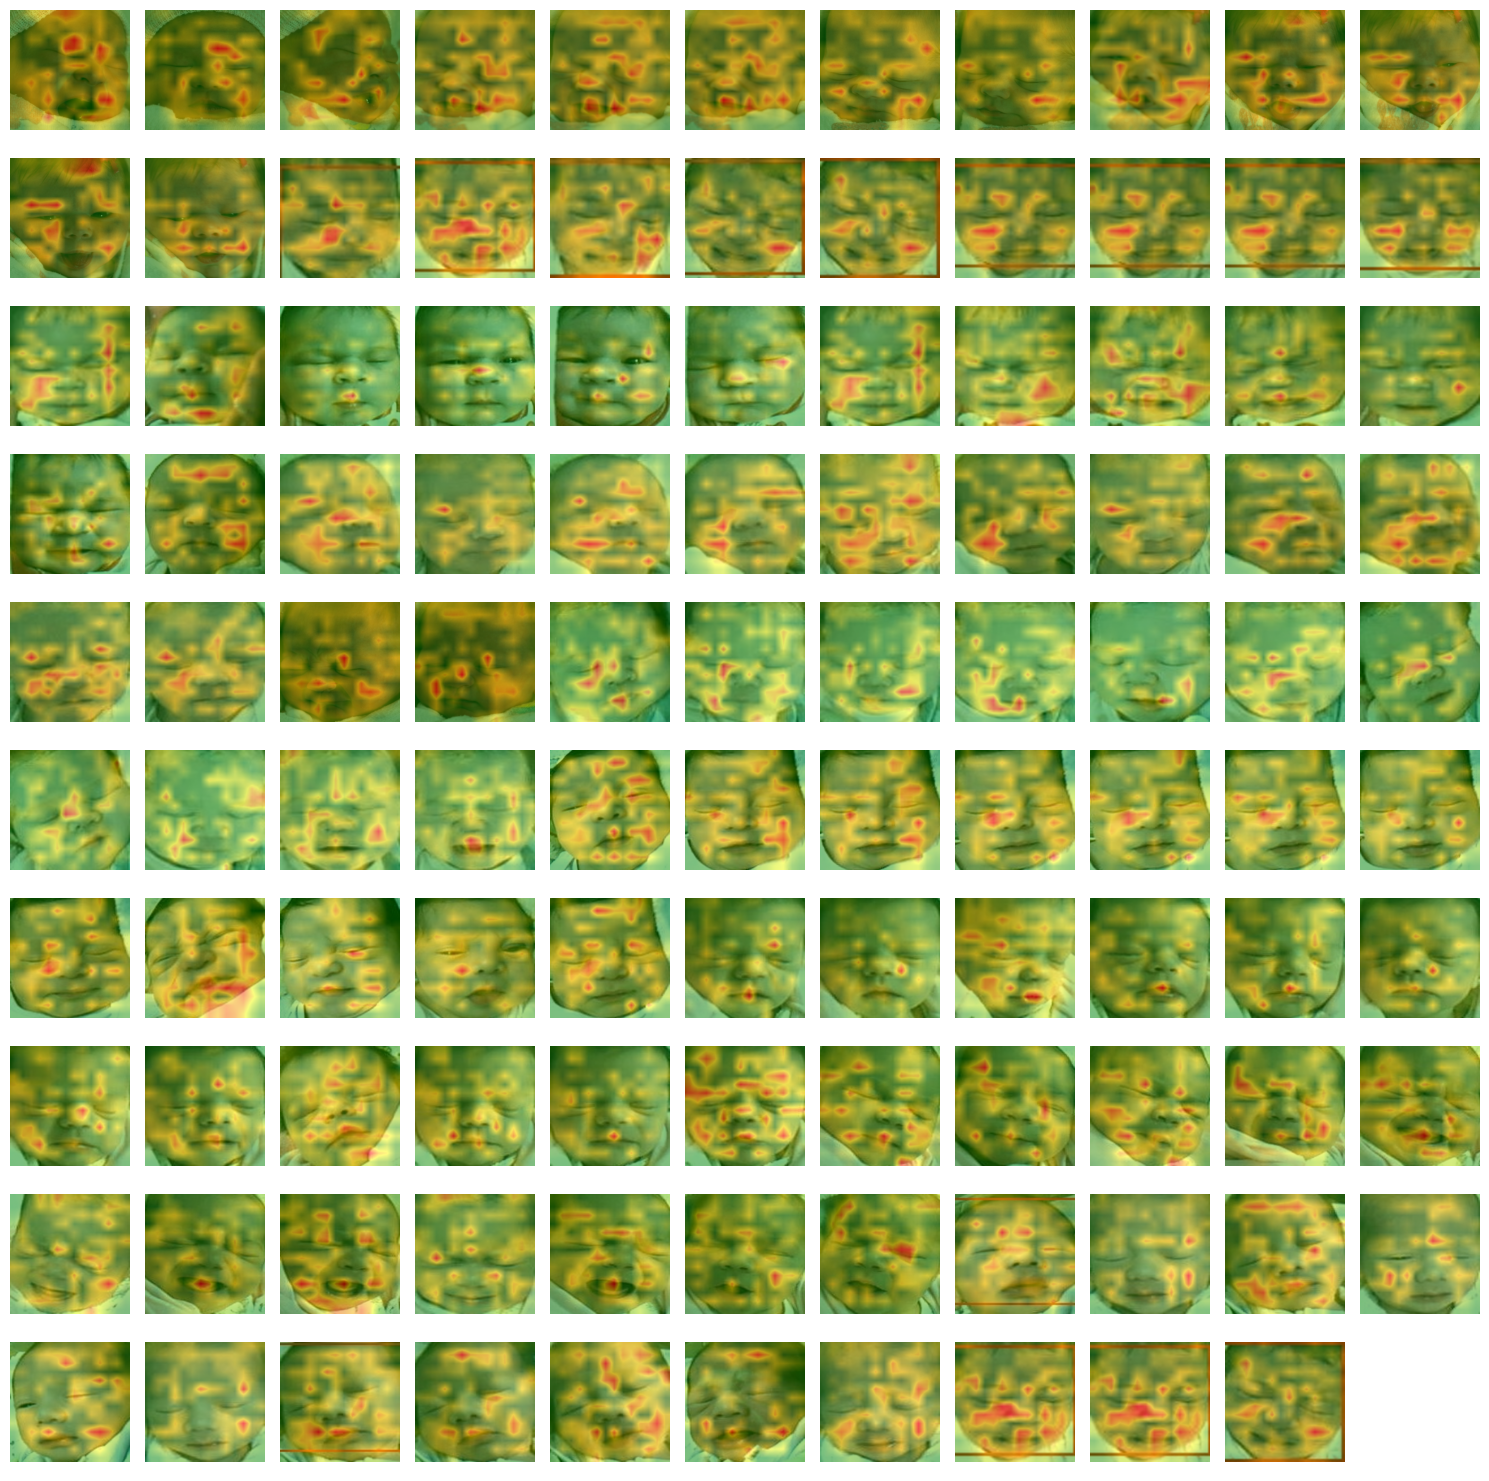

In [14]:
plot_image_grid(images, mask_gc, figsize=(15, 15), img_size=img_size)

In [19]:
ig = IntegratedGradients(model, device='cuda')
mask_ig = ig.attribution_mask(transformed_images)

In [20]:
mask_ig[1].max()

0.9999994

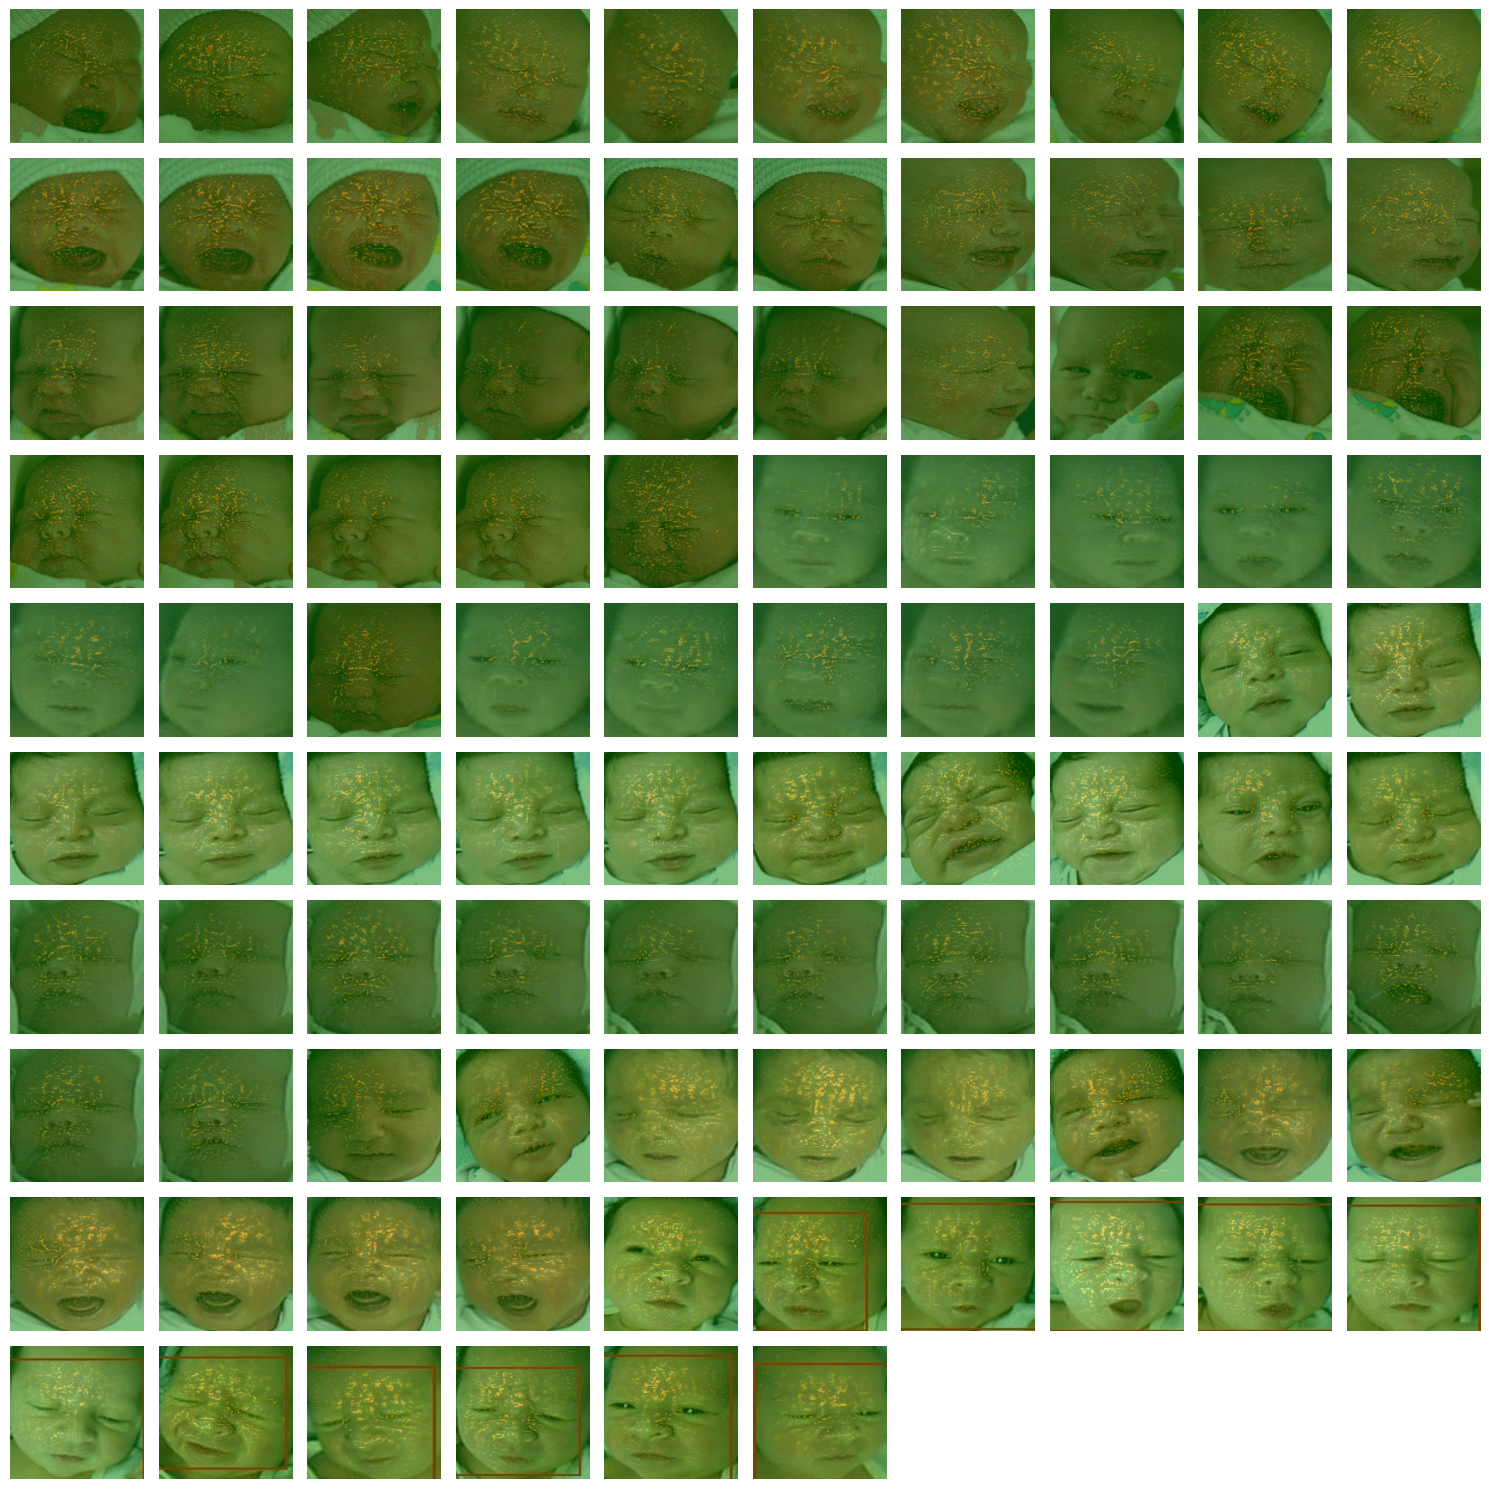

In [21]:
plot_image_grid(images, mask_ig, figsize=(15, 15), img_size=img_size)

In [22]:
model

PainClassifier(
  (arcface_model): VGG16(
    (vgg): VGG(
      (features): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU(inplace=True)
        (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (6): ReLU(inplace=True)
        (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (8): ReLU(inplace=True)
        (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (11): ReLU(inplace=True)
        (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (13): ReLU(inplace=True)
        (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1

In [13]:
model.arcface_model.vgg.features[24:]

Sequential(
  (24): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (25): ReLU(inplace=True)
  (26): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (27): ReLU(inplace=True)
  (28): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (29): ReLU(inplace=True)
  (30): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

# CAPTUM

In [1]:
from torchvision import models, transforms
from PIL import Image
import torch
from models import *
import matplotlib.pyplot as plt 
import numpy as np
import torch.nn as nn

In [2]:
from captum.attr import visualization as viz
from dataloaders import presets

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
model = VGGFace()

checkpoint = torch.load('D:\\### DOUTORADO\\Mestrado\\experiments\\VGGFace\\20250718_1246_VGGFace\\Model\\best_model.pt', weights_only=False)
model.load_state_dict(checkpoint)
model.eval()

VGGFace(
  (VGGFace): VGG(
    (features): Sequential(
      (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_1): ReLU(inplace=True)
      (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu1_2): ReLU(inplace=True)
      (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_1): ReLU(inplace=True)
      (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu2_2): ReLU(inplace=True)
      (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_1): ReLU(inplace=True)
      (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3_2): ReLU(inplace=True)
      (conv3_3): Conv2d(256, 256, kernel_size

In [4]:
val_transforms = presets.PresetTransform("VGGFace").transforms

In [5]:
val_transforms

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    PILToTensor()
    ConvertImageDtype()
    Normalize(mean=[0.367, 0.41, 0.506], std=[1, 1, 1])
)

In [66]:
id = 'ID405_UNIFESP_S37_pain'

In [67]:
img_RGB = Image.open(f'Datasets/Folds/0/Test/{id}.jpg')

In [68]:
img = Image.fromarray(np.array(img_RGB)[:, :, ::-1])

In [69]:
img_transformed = val_transforms(img)
img_transformed = img_transformed.unsqueeze(0)

In [70]:
model(img_transformed)

tensor([4.7188], grad_fn=<ViewBackward0>)

In [71]:
import numpy as np

def normalize_0_1(matrix):
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(matrix)


## Integrated Gradients

In [12]:
from captum.attr import IntegratedGradients
from captum.attr import NoiseTunnel

In [13]:
ig = IntegratedGradients(model)

In [14]:
attr = ig.attribute(img_transformed)

In [15]:
attr.shape

torch.Size([1, 3, 224, 224])

In [16]:
attr = attr[0].cpu().detach().numpy()
attr = attr.transpose(1, 2, 0)

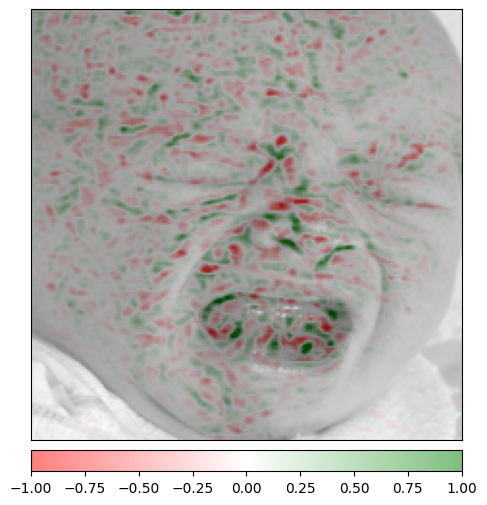

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [17]:
viz.visualize_image_attr(attr, 
                         original_image=img_RGB.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## Saliency

In [25]:
from captum.attr import Saliency

In [26]:
saliency = Saliency(model)

In [27]:
attr = saliency.attribute(img_transformed, abs=False)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\attr\_core\saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)


In [28]:
attr.shape

torch.Size([1, 3, 224, 224])

In [29]:
attr = attr[0].cpu().detach().numpy()
attr = attr.transpose(1, 2, 0)

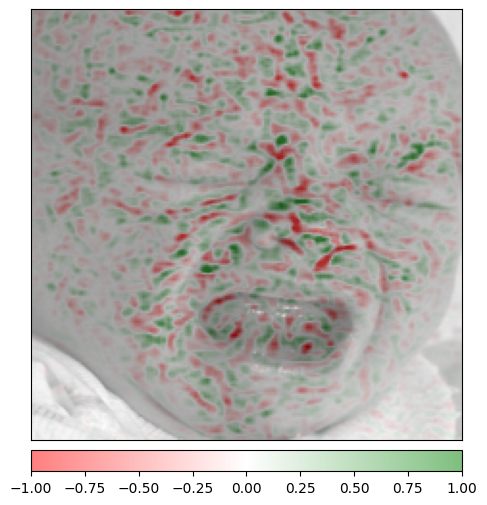

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [30]:
viz.visualize_image_attr(attr, 
                         original_image=img.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## DeepLift

In [31]:
from captum.attr import DeepLift

In [32]:
dl = DeepLift(model)

In [33]:
attr = dl.attribute(img_transformed)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\attr\_core\deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\log\dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


In [34]:
attr.shape

torch.Size([1, 3, 224, 224])

In [35]:
attr = attr[0].cpu().detach().numpy()
attr = attr.transpose(1, 2, 0)

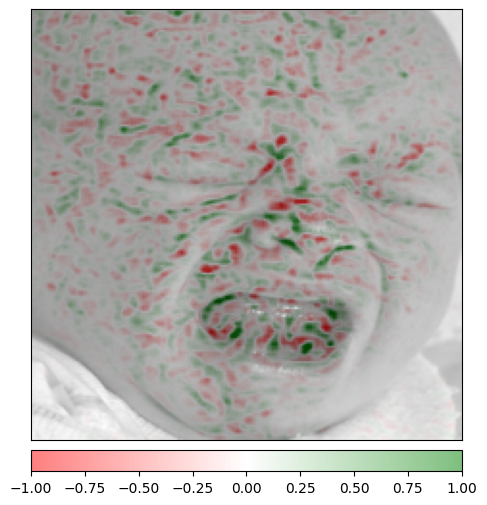

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [36]:
viz.visualize_image_attr(attr, 
                         original_image=img.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## Occlusion

In [37]:
from captum.attr import Occlusion

In [38]:
ablator = Occlusion(model)

In [ ]:
attr = ablator.attribute(img_transformed, sliding_window_shapes=(3,5,5))

In [ ]:
attr.shape

In [ ]:
attr = attr[0].cpu().detach().numpy()
attr = attr.transpose(1, 2, 0)

In [ ]:
viz.visualize_image_attr(attr, 
                         original_image=img.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## GradCAM


In [40]:
from captum.attr import LayerGradCam
from captum.attr import LayerAttribution

In [42]:
#NCNN layer_gc = LayerGradCam(model, model.merge_branch[0])
layer_gc = LayerGradCam(model, model.VGGFace.features.conv5_3)

In [43]:
attr = layer_gc.attribute(img_transformed)
upsampled_attr = LayerAttribution.interpolate(attr, (224, 224), interpolate_mode="bilinear")

In [44]:
upsampled_attr.shape

torch.Size([1, 1, 224, 224])

In [45]:
upsampled_attr = upsampled_attr[0].cpu().detach().numpy()
upsampled_attr = upsampled_attr.transpose(1, 2, 0)

In [ ]:
viz.visualize_image_attr(upsampled_attr, 
                         original_image=img.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## LIME

In [12]:
from captum.attr import Lime
import torch
from captum.attr import visualization as viz

In [13]:
lime = Lime(model)
attr = lime.attribute(img_transformed, n_samples=50)

c:\Users\leona\anaconda3\envs\doutorado\lib\site-packages\captum\attr\_core\lime.py:1141: UserWarning: Attempting to construct interpretable model with > 10000 features.This can be very slow or lead to OOM issues. Please provide a featuremask which groups input features to reduce the number of interpretablefeatures. 
  warnings.warn(


In [17]:
attr = attr[0].cpu().detach().numpy()
attr = attr.transpose(1, 2, 0)

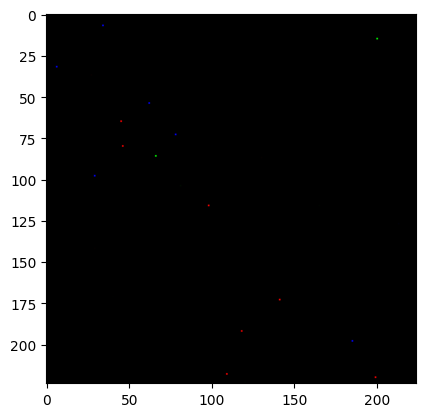

In [22]:
plt.imshow(np.uint8(attr*255))

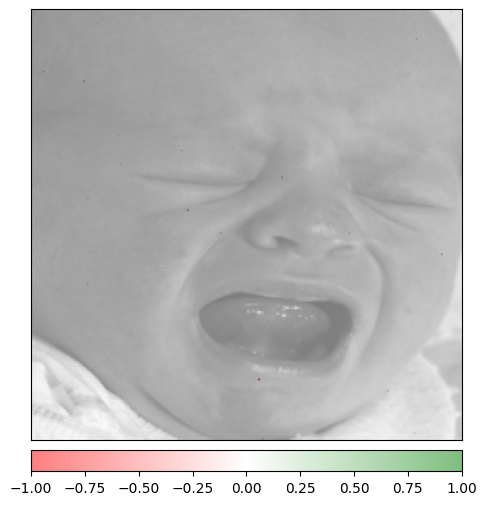

(<Figure size 600x600 with 2 Axes>, <Axes: >)

In [18]:
viz.visualize_image_attr(attr, 
                         original_image=img_RGB.resize((224,224)),
                         method="blended_heat_map",
                         sign="all",
                         show_colorbar=True,)

## LIME with Facial Features

In [72]:
from captum.attr import Lime
from XAI.metrics import  create_face_regions_masks
import pickle
from utils import resize_landmarks
import cv2
import torch
from captum.attr import visualization as viz


In [73]:
with open(f'Datasets/DatasetFaces/Landmarks/{id}.pkl', 'rb') as f:
    landmarks = pickle.load(f)

In [74]:
test = create_face_regions_masks(landmarks)

test['eyes'] = test['right_eye'] + test['left_eye']
test['eyebrown'] = test['right_eyebrown'] + test['left_eyebrown']
test['nasolabial_fold'] = test['right_nasolabial_fold'] + test['left_nasolabial_fold']
test['cheek'] = test['right_cheek'] + test['left_cheek']

test.pop('right_eye')
test.pop('left_eye')
test.pop('right_eyebrown')
test.pop('left_eyebrown')
test.pop('right_nasolabial_fold')
test.pop('left_nasolabial_fold')
test.pop('right_cheek')
test.pop('left_cheek')
test.pop('outside')


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)

In [75]:
features = np.zeros((224,224))

for i,mask in enumerate(test):
    features[np.where(cv2.resize(test[mask], (224,224), interpolation=cv2.INTER_NEAREST) == 1)] = i

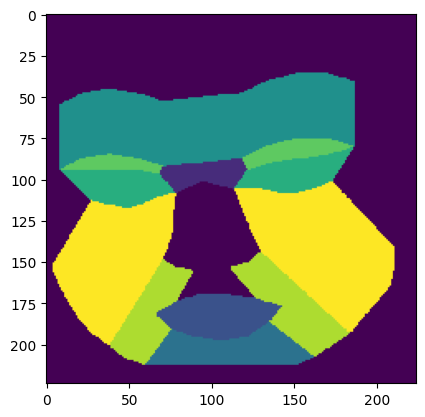

In [76]:
plt.imshow(features)

In [77]:
features.shape

(224, 224)

In [78]:
features = np.stack([features] * 3, axis=0)

In [79]:
features.shape

(3, 224, 224)

In [80]:
from captum.attr._core.lime import get_exp_kernel_similarity_function
from captum._utils.models.linear_model import SkLearnLinearRegression, SkLearnLasso


In [81]:
exp_eucl_distance = get_exp_kernel_similarity_function('euclidean', kernel_width=1000)


In [82]:
def iter_combinations(*args, **kwargs):
    for i in range(2 **  len(test)):
        yield torch.tensor([int(d) for d in bin(i)[2:].zfill( len(test))]).unsqueeze(0)

In [83]:
lr_lime = Lime(
    model, 
    interpretable_model=SkLearnLasso(alpha=0.08),  # build-in wrapped sklearn Linear Regression
    similarity_func=exp_eucl_distance,
    perturb_func=iter_combinations
)

In [84]:
attrs = lr_lime.attribute(
    img_transformed,
    feature_mask=torch.tensor(features, dtype=torch.int64),
    n_samples=2 ** len(test),
    perturbations_per_eval=16,
    show_progress=True
).squeeze(0)

Lime attribution: 100%|██████████| 32/32 [00:51<00:00,  1.59s/it]


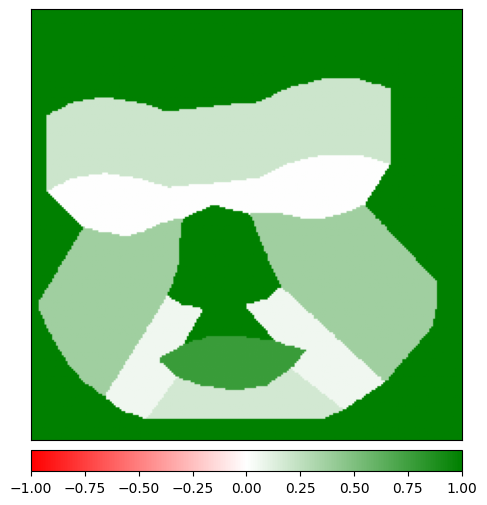

In [85]:
def show_attr(attr_map):
    viz.visualize_image_attr(
        attr_map.permute(1, 2, 0).numpy(),  # adjust shape to height, width, channels 
        method='heat_map',
        sign='all',
        show_colorbar=True
    )
    
show_attr(attrs.cpu().detach())

## GradientShap


In [ ]:
from captum.attr import GradientShap

In [ ]:
gradient_shap = GradientShap(model)

In [ ]:
baselines = torch.randn(20, 3, 120, 120, device=device)

In [ ]:
attribution = gradient_shap.attribute(img_transformed, baselines)

In [ ]:
attribution = attribution.squeeze().cpu().numpy().transpose(1, 2, 0)

In [ ]:
import cv2

In [ ]:
attribution = normalize_0_1(attribution)
attribution = cv2.cvtColor(attribution, cv2.COLOR_RGB2GRAY)

In [ ]:
plt.imshow(img.resize((120,120)))
plt.imshow(attribution, cmap='jet', alpha=0.5)


## Guided GradCAM

In [ ]:
from captum.attr import GuidedGradCam

In [ ]:
guided_gc = GuidedGradCam(model, model.conv_4)

In [ ]:
attribution = guided_gc.attribute(img_transformed)

In [ ]:
attribution.shape

In [ ]:
attribution = attribution.squeeze().detach().cpu().numpy().transpose(1, 2, 0)

In [ ]:
attribution = normalize_0_1(attribution)
#attribution = cv2.cvtColor(attribution, cv2.COLOR_RGB2GRAY)

In [ ]:
plt.imshow(img.resize((120,120)))
plt.imshow(attribution, cmap='jet', alpha=0.8)


## Layer Activation

In [ ]:
from captum.attr import LayerActivation

In [ ]:
layer_act = LayerActivation(model, model.vgg.features[28])

In [ ]:
attribution = layer_act.attribute(img_transformed)

In [ ]:
attribution.shape

In [ ]:
attribution = attribution.detach().cpu().numpy()

In [ ]:
# Determine grid size (e.g., 8x8)
images = attribution[0]
grid_size = int(np.ceil(np.sqrt(len(images))))

fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

for i in range(grid_size * grid_size):
    ax = axes[i // grid_size, i % grid_size]
    if i < len(images):
        ax.imshow(images[i], cmap='gray', interpolation='nearest')
    ax.axis('off')  # Hide axes

plt.tight_layout()
plt.show()

## RISE

In [1]:
from XAI import RISE
from models import NCNN, VGGFace
import torch
from dataloaders import presets
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [2]:
device = "cuda"

In [3]:
model = VGGFace()
model.load_state_dict(torch.load('D:\\### DOUTORADO\\Mestrado\\experiments\\VGGFace_FINAL\\20250826_1353_VGGFace\\Model\\best_model.pt', map_location=torch.device('cpu'))) #pretreinado

transform = presets.PresetTransform("VGGFace").transforms

In [16]:
img = Image.open(f'Datasets/Folds/0/Test/ID405_UNIFESP_S37_pain.jpg').convert("RGB")
img = Image.fromarray(np.array(img)[:, :, ::-1])

In [5]:
rise = RISE(model, input_size=(224,224), gpu_batch=10, device=device)

In [6]:
rise.generate_masks(1000, 8, 0.1)

Generating RISE masks: 100%|██████████| 1000/1000 [00:01<00:00, 882.04it/s]


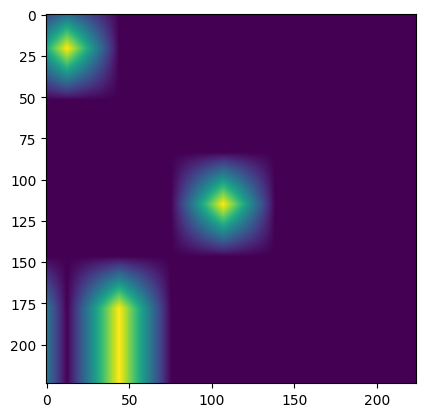

In [7]:
plt.imshow(rise.masks[0].cpu()[0])

In [17]:
model.predict(transform(img).unsqueeze(0).to(device))

tensor([0.9816], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [18]:
mask = rise.attribution_mask(transform(img).unsqueeze(0).to(device))

tensor([0.2280, 0.1843, 0.2787, 0.2542, 0.4092, 0.2403, 0.1617, 0.4791, 0.1941,
        0.1730, 0.1560, 0.1777, 0.5717, 0.2354, 0.6891, 0.1312, 0.2620, 0.3874,
        0.3948, 0.2526, 0.3830, 0.2415, 0.3068, 0.3556, 0.1687, 0.2797, 0.3843,
        0.4692, 0.2354, 0.6390, 0.1915, 0.1774, 0.1718, 0.3050, 0.3134, 0.5816,
        0.2800, 0.2457, 0.1520, 0.2512, 0.5998, 0.3627, 0.2522, 0.4837, 0.1235,
        0.2573, 0.3241, 0.1751, 0.2572, 0.4465, 0.3168, 0.4066, 0.2852, 0.1617,
        0.3779, 0.2147, 0.6209, 0.1854, 0.4681, 0.2596, 0.2662, 0.2342, 0.2399,
        0.1940, 0.1614, 0.3805, 0.4993, 0.5857, 0.3347, 0.2560, 0.1744, 0.2132,
        0.5094, 0.2505, 0.1944, 0.3069, 0.2428, 0.2382, 0.2880, 0.4876, 0.3795,
        0.2499, 0.2628, 0.3812, 0.1170, 0.2127, 0.2188, 0.1464, 0.2341, 0.2242,
        0.3378, 0.2545, 0.1088, 0.2534, 0.2653, 0.2632, 0.4542, 0.2580, 0.2729,
        0.2768, 0.2509, 0.2567, 0.2197, 0.1778, 0.3248, 0.2044, 0.5008, 0.5161,
        0.2020, 0.1807, 0.4302, 0.2428, 

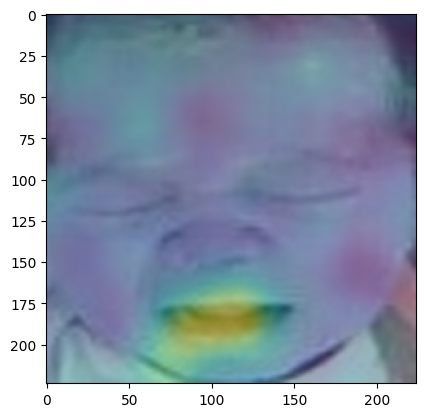

In [19]:
plt.imshow(mask.cpu())
plt.imshow(img.resize((224,224)), alpha=0.5)